In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import findspark
import os
findspark.init(os.environ['SPARK_HOME'])
from pyspark.sql import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

%matplotlib inline

spark = SparkSession.builder.getOrCreate()

In [3]:
dataframe = pd.read_csv('../data/processed/clean_food_and_cities.csv')

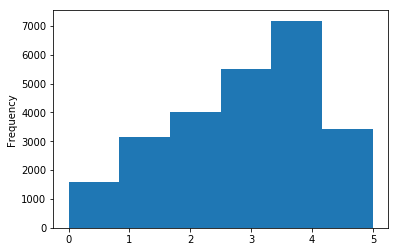

In [7]:
# we plot the general distribution of the nutrition grade for all remaining products
dataframe['nutrition_grade_numeric'].plot.hist(bins=6)

We see that most of the products are labeled with a `3` or below, which indicates that healthy products are rare in comparison. 

Reminder: `0` is equivalent to no data.